**Importing all the important libraries**

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from lime import lime_tabular
from mediapipe_handler import MediaPipeHandler
# from get_work_out_labels import add_workout_label_back, add_muscle_groups_label
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


**Workflow**
1. Loading Training and Testing Datasets
2. Add Label string values
3. Looking at workout distributions
4. Preprocessing
5. Feature Engineering
6. Train Random Forest with hyperparameters [with and without feature engineering]
7. Train Neural Network with hyperparameters [with and without feature engineering]
8. Train SVM with hyperparameters [with and without feature engineering]
9. Compare model performance in terms of SPEED,ACCURACY,PERCISION,RECALL,F1-SCORE
10. Do the same process but with SMOTE to handle imbalance classes, then compare accuracy

**1. Loading Training and Testing Datasets**

In [35]:
mediapipe_model = MediaPipeHandler()

training_dataset=mediapipe_model.read_csv_to_pd("/Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/data/train_new.csv")
testing_dataset=mediapipe_model.read_csv_to_pd("/Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/data/test_new.csv")

current OS working directory is /Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/app


I0000 00:00:1744672106.474006 20225481 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1744672106.545066 20354285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744672106.554827 20354292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


**2. Add Label String Values**

In [36]:
# training_dataset['muscle group']=training_dataset.apply(lambda x: add_muscle_groups_label(x['label']) ,axis=1)

**3. Looking at Workout Distribution**

In [37]:
Workout_labels=training_dataset['muscle group'].unique()

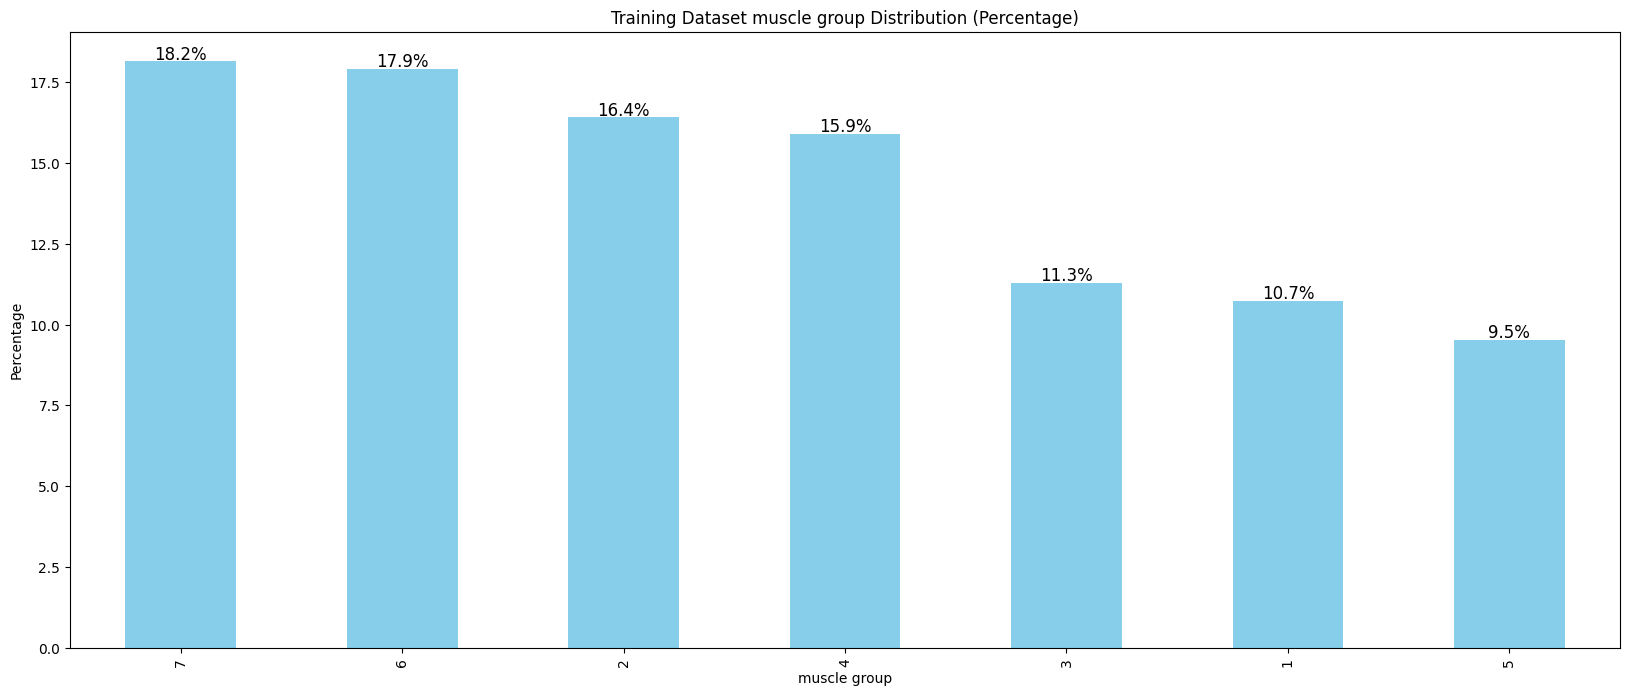

In [38]:
plt.figure(figsize=(20,8))
value_counts = training_dataset['muscle group'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Plot
ax = percentages.plot(kind='bar', color='skyblue')

# Add percentage text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Training Dataset muscle group Distribution (Percentage)')
plt.ylabel('Percentage')
plt.show()

**4. Preprocessing**

**We have to make sure that we get right of Unamed 0: column, as it just contains numerical index not very useful, might lead to overfitting if it is left**
- Get rid of Unnamed 0:
- Get rid of image
- Get rid of muscle group
- split each feature into x,y,z components, then remove that original feature


In [39]:
training_dataset

,Unnamed: 0,image,label,muscle group,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,...,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,left_heel,right_heel,left_foot_index,right_foot_index
0,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,3,"[0.5833196, 0.33580318, -0.21178767]","[0.47458136, 0.34345636, 0.10874679]","[0.57977086, 0.46415919, -0.47176945]","[0.43594614, 0.45717493, 0.02466545]","[0.56032622, 0.30753931, -0.67780912]","[0.41948569, 0.34880683, -0.22920853]",...,"[0.54745519, 0.64153045, -0.09524324]","[0.4949941, 0.63739824, 0.0950451]","[0.5395903, 0.87229109, -0.12797548]","[0.47882056, 0.83482677, 0.09046733]","[0.57926077, 1.00452185, 0.16046034]","[0.49489287, 1.00004327, 0.30162144]","[0.59262854, 1.01897967, 0.18326579]","[0.50915658, 1.01278317, 0.31755036]","[0.54145193, 1.08223307, 0.05403144]","[0.45173571, 1.07756639, 0.19764052]"
1,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,3,"[0.67864227, 0.44007847, -0.61281157]","[0.51508331, 0.35392922, -0.11702637]","[0.67732167, 0.74100083, -0.5522756]","[0.4897728, 0.60025042, 0.07598472]","[0.61691177, 0.97857672, -0.45322162]","[0.45017678, 0.78440237, 0.03856679]",...,"[0.58077621, 0.82892936, -0.14173837]","[0.51025462, 0.78014213, 0.14235109]","[0.54428422, 1.10362673, -0.05568497]","[0.50352174, 1.00672913, 0.34694716]","[0.55549401, 1.30219674, 0.41977754]","[0.49522635, 1.25586081, 0.75884837]","[0.57307285, 1.33680952, 0.45630074]","[0.49889699, 1.29905045, 0.79597855]","[0.4998886, 1.36149573, 0.31691936]","[0.43795371, 1.30396044, 0.67758882]"
2,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,3,"[0.69693595, 0.42484942, -0.54643494]","[0.5414809, 0.3626397, 0.05607326]","[0.69159269, 0.72796458, -0.47757795]","[0.50304294, 0.59366345, 0.26994297]","[0.60007864, 0.97318113, -0.33487263]","[0.4317157, 0.74968982, 0.221766]",...,"[0.6004225, 0.86410141, -0.14862862]","[0.5276618, 0.81493449, 0.149377]","[0.56669152, 1.1428107, -0.0867893]","[0.51520008, 1.03812408, 0.34105164]","[0.56008267, 1.35045171, 0.33445409]","[0.50417012, 1.30311942, 0.71437806]","[0.57579422, 1.38513505, 0.36577019]","[0.50641191, 1.34992421, 0.74796361]","[0.49819234, 1.41932583, 0.23056105]","[0.4493897, 1.35124731, 0.64058065]"
3,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,3,"[0.73515791, 0.42139792, -0.44522965]","[0.56772029, 0.33572495, -0.02038416]","[0.71257848, 0.69318485, -0.42954224]","[0.52117139, 0.53452033, 0.11454836]","[0.57872039, 0.74771893, -0.41099623]","[0.42096221, 0.56698191, -0.03880053]",...,"[0.63282323, 0.8161276, -0.11761034]","[0.55607569, 0.75885957, 0.11806498]","[0.56389433, 1.0513351, -0.05874701]","[0.52235311, 0.98940063, 0.26710114]","[0.62840301, 1.19985843, 0.27531052]","[0.5560208, 1.18725681, 0.54255092]","[0.65617859, 1.22073638, 0.30534539]","[0.57421941, 1.22636902, 0.57130569]","[0.59127408, 1.28368247, 0.25454187]","[0.49074861, 1.25892329, 0.53612298]"
4,4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,3,"[0.74208808, 0.42787308, -0.40222892]","[0.56917161, 0.36541611, 0.02321619]","[0.71893549, 0.71135747, -0.33957008]","[0.51690018, 0.55520439, -0.06789815]","[0.59105009, 0.64484054, -0.20590726]","[0.42900956, 0.49844888, -0.50125289]",...,"[0.63502121, 0.86177504, -0.09993926]","[0.54234886, 0.81430739, 0.10102117]","[0.59540391, 1.14598823, 0.00768962]","[0.50538111, 1.11401439, 0.41538179]","[0.57525152, 1.37389243, 0.27296644]","[0.50017542, 1.35379958, 0.76125646]","[0.58630925, 1.4121573, 0.29041424]","[0.50934988, 1.40208185, 0.79376227]","[0.51287192, 1.45682466, 0.128802]","[0.43914852, 1.42183828, 0.67137176]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69843,69843,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,5,"[0.61858006, 0.25968396, 0.20608076]","[0.67953396, 0.24306432, -0.11037624]","[0.62321505, 0.39104626, 0.20724858]","[0.694639, 0.31550396, -0.15340711]","[0.61830718, 0.46403

In [40]:
training_dataset['left_ankle']

0        [0.57926077, 1.00452185, 0.16046034]
1        [0.55549401, 1.30219674, 0.41977754]
2        [0.56008267, 1.35045171, 0.33445409]
3        [0.62840301, 1.19985843, 0.27531052]
4        [0.57525152, 1.37389243, 0.27296644]
                         ...                 
69843    [0.63271011, 0.87930678, 0.11657207]
69844    [0.27464361, 0.86654581, 0.38527734]
69845    [0.29924359, 0.87102715, 0.34216703]
69846    [0.59200093, 0.76675438, 0.26883874]
69847    [0.18935676, 0.79994411, 0.32324325]
Name: left_ankle, Length: 69848, dtype: object

In [41]:
"""
Removes original feature and splits it into x,y,z components

"""
def Preprocess_data(dataframe,columns_to_flatten):
    final_df=dataframe.copy()
    # Expanding each column into 3 separate columns (x, y, z) and appending it to the final dataframe.
    for column in columns_to_flatten:
        # print(np.vstack(dataframe[column]).astype(float))
        expanded_df=pd.DataFrame(np.vstack(dataframe[column]).astype(float), 
                           columns=[column+'_x', column+'_y', column+'_z'],
                           index=dataframe.index)
        new_df = pd.concat([dataframe.drop(column, axis=1), expanded_df], axis=1)
        for new_column in new_df.columns:
            final_df[new_column] = new_df[new_column]

    return final_df.drop(columns=columns_to_flatten,axis=1)

"""
Splits dataset into X_train,y_train or X_test,y_test, if you give it training dataset then X_train and y_train

"""
def Return_X_y(dataframe,columns_to_delete):
    X=dataframe.drop(columns=columns_to_delete)
    y=dataframe['muscle group']
    return X,y

In [42]:
features_to_split=['left_shoulder',
       'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
       'right_wrist', 'left_pinky', 'right_pinky', 'left_index', 'right_index',
       'left_thumb', 'right_thumb', 'left_hip', 'right_hip', 'left_knee',
       'right_knee', 'left_ankle', 'right_ankle', 'left_heel', 'right_heel',
       'left_foot_index', 'right_foot_index']

training_dataset_preprocessed=Preprocess_data(training_dataset,features_to_split)
X_train, y_train = Return_X_y(training_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])


testing_dataset_preprocessed=Preprocess_data(testing_dataset,features_to_split)
X_test, y_test = Return_X_y(testing_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

In [43]:
print("X_train Shape",X_train.shape)

print("y_train Shape",y_train.shape)

print("X_test Shape",X_test.shape)

print("y_test Shape",y_test.shape)

X_train Shape (69848, 66)
y_train Shape (69848,)
X_test Shape (10032, 66)
y_test Shape (10032,)


**66 Features is all the features**

**5. Feature Engineering**

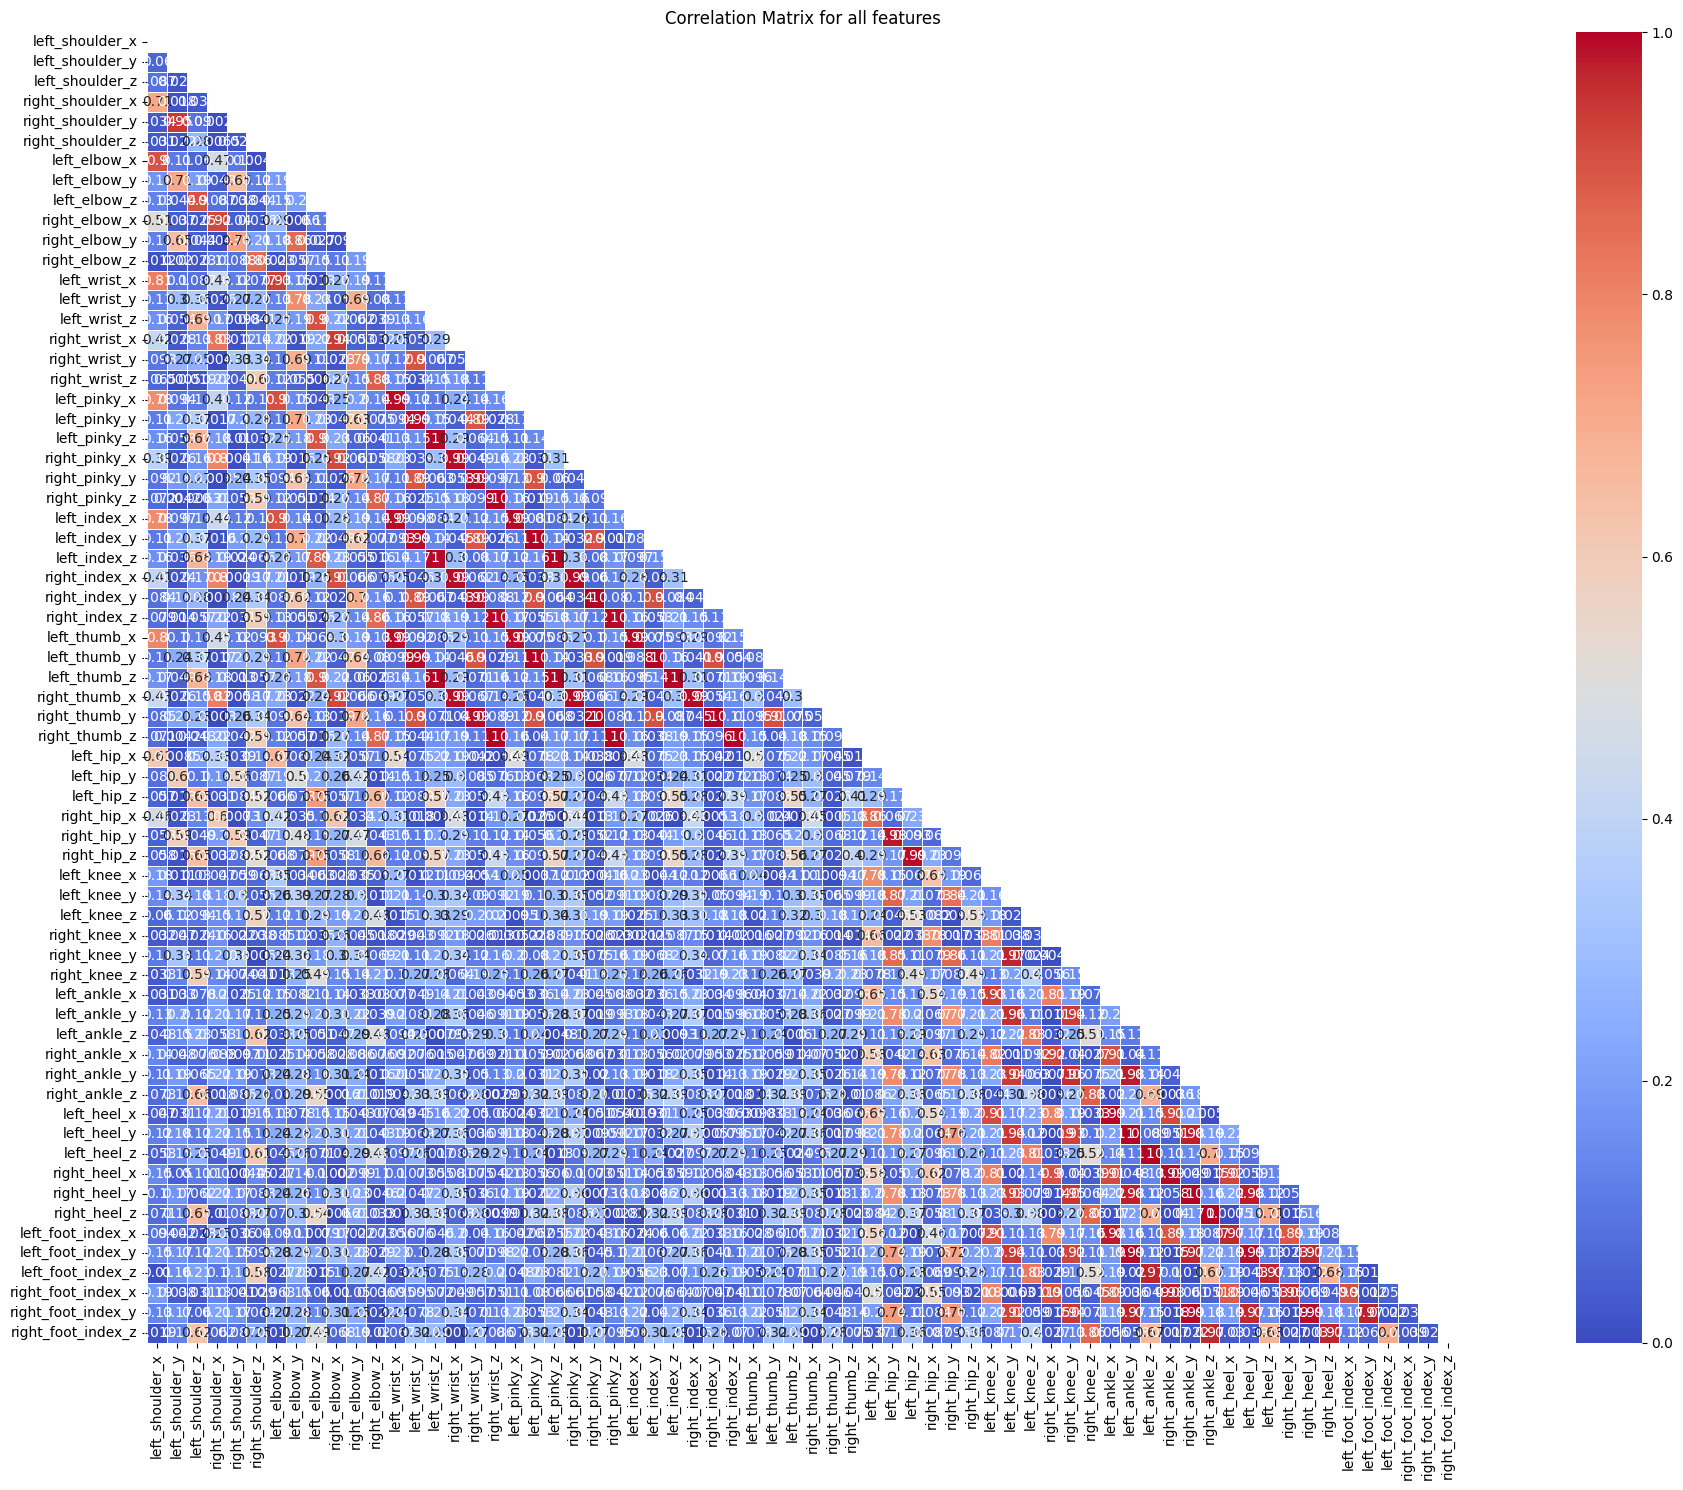

In [44]:
corr_matrix = X_train.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(24, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            vmax=1.0, vmin=0, center=0.5,
            square=True, linewidths=.5, annot=True).set(title='Correlation Matrix for all features')
plt.tight_layout()
plt.show()

**Features that are highly correlated , one of them should be removed**
- it is better to remove the one that is the least correlated with y_target

In [45]:
correlation_threshold = 0.8
columns_to_drop = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > correlation_threshold:
            columns_to_drop.append(corr_matrix.columns[j])
            print(f"High Correlation between {corr_matrix.columns[i]} and {corr_matrix.columns[j]} --> {corr_matrix.iloc[i, j]:.2f}")

columns_to_drop = list(set(columns_to_drop))
print(f"Columns to drop: {columns_to_drop}")
print(f"number of columns to drop: {len(columns_to_drop)}")

High Correlation between left_shoulder_x and left_elbow_x --> 0.90
High Correlation between left_shoulder_x and left_wrist_x --> 0.81
High Correlation between left_shoulder_y and right_shoulder_y --> 0.95
High Correlation between left_shoulder_z and left_elbow_z --> 0.90
High Correlation between right_shoulder_x and right_elbow_x --> 0.92
High Correlation between right_shoulder_x and right_wrist_x --> 0.83
High Correlation between right_shoulder_x and right_index_x --> 0.80
High Correlation between right_shoulder_x and right_thumb_x --> 0.82
High Correlation between right_shoulder_z and right_elbow_z --> 0.86
High Correlation between left_elbow_x and left_wrist_x --> 0.93
High Correlation between left_elbow_x and left_pinky_x --> 0.90
High Correlation between left_elbow_x and left_index_x --> 0.90
High Correlation between left_elbow_x and left_thumb_x --> 0.90
High Correlation between left_elbow_y and right_elbow_y --> 0.86
High Correlation between left_elbow_z and left_wrist_z --> 0.9

In [46]:
print(f"Columns to drop: {columns_to_drop}")


Columns to drop: ['right_elbow_z', 'left_index_z', 'right_knee_y', 'left_elbow_x', 'right_elbow_x', 'left_wrist_z', 'left_heel_z', 'left_wrist_x', 'right_heel_z', 'right_heel_y', 'right_pinky_z', 'right_hip_z', 'left_pinky_y', 'left_thumb_z', 'left_index_y', 'right_pinky_y', 'left_ankle_z', 'left_knee_y', 'right_thumb_z', 'left_pinky_x', 'left_pinky_z', 'right_ankle_z', 'left_heel_x', 'right_index_x', 'right_wrist_z', 'left_ankle_x', 'right_heel_x', 'left_foot_index_y', 'right_foot_index_y', 'right_thumb_y', 'left_heel_y', 'left_thumb_y', 'right_foot_index_z', 'left_index_x', 'right_pinky_x', 'left_ankle_y', 'left_foot_index_z', 'right_ankle_y', 'right_thumb_x', 'right_wrist_y', 'right_wrist_x', 'right_elbow_y', 'right_index_z', 'right_index_y', 'right_ankle_x', 'left_foot_index_x', 'right_foot_index_x', 'right_shoulder_y', 'left_thumb_x', 'left_elbow_z', 'right_hip_x', 'right_hip_y', 'right_knee_x']


**53 Columns to drop**

In [47]:
X_train_feature_eng=X_train.drop(columns=columns_to_drop)
X_test_feature_eng=X_test.drop(columns=columns_to_drop)

In [48]:
X_train_feature_eng

,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_z,left_elbow_y,left_wrist_y,left_hip_x,left_hip_y,left_hip_z,left_knee_x,left_knee_z,right_knee_z
0,0.583320,0.335803,-0.211788,0.474581,0.108747,0.464159,0.307539,0.547455,0.641530,-0.095243,0.539590,-0.127975,0.090467
1,0.678642,0.440078,-0.612812,0.515083,-0.117026,0.741001,0.978577,0.580776,0.828929,-0.141738,0.544284,-0.055685,0.346947
2,0.696936,0.424849,-0.546435,0.541481,0.056073,0.727965,0.973181,0.600422,0.864101,-0.148629,0.566692,-0.086789,0.341052
3,0.735158,0.421398,-0.445230,0.567720,-0.020384,0.693185,0.747719,0.632823,0.816128,-0.117610,0.563894,-0.058747,0.267101
4,0.742088,0.427873,-0.402229,0.569172,0.023216,0.711357,0.644841,0.635021,0.861775,-0.099939,0.595404,0.007690,0.415382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69843,0.618580,0.259684,0.206081,0.679534,-0.110376,0.391046,0.464040,0.646778,0.527180,0.105258,0.647785,0.116731,-0.095439
69844,0.245663,0.254866,0.294633,0.351152,-0.221698,0.360288,0.330697,0.240152,0.530615,0.187655,0.283458,0.290765,-0.241217
69845,0.247749,0.280684,0.313076,0.399396,-0.215537,0.407808,0.464591,0.303514,0.499275,0.176702,0.312391,0.243403,-0.108539
69846,0.654701,0.311099,-0.048359,0.598954,-0.350883,0.402526,0.498179,0.614427,0.502922,0.080030,0.602597,0.108630,-0.133366


In [49]:
X_train.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z',
       'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y',
       'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z',
       'left_pinky_x', 'left_pinky_y', 'left_pinky_z', 'right_pinky_x',
       'right_pinky_y', 'right_pinky_z', 'left_index_x', 'left_index_y',
       'left_index_z', 'right_index_x', 'right_index_y', 'right_index_z',
       'left_thumb_x', 'left_thumb_y', 'left_thumb_z', 'right_thumb_x',
       'right_thumb_y', 'right_thumb_z', 'left_hip_x', 'left_hip_y',
       'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z',
       'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x',
       'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y',
       'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z',
       'lef

In [50]:
X_train_feature_eng.columns
# y_train.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_z', 'left_elbow_y', 'left_wrist_y',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_knee_x', 'left_knee_z',
       'right_knee_z'],
      dtype='object')

In [51]:
"""
This function takes both training_dataset
then it will show the result for each one of the models

1-Accuracy
2-Classification Report
3-Confusion Matrix
4-Precision, Recall, F1-Score
5-Time Taken to train
6-Features used to build the model

"""

def train_model(model,param_grid,X_train,y_train,X_test,y_test):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=2,
        scoring='accuracy'
    )
    grid_search.fit(X_train,y_train)
    y_predictions=grid_search.predict(X_test)
    accuracy = accuracy_score(y_test,y_predictions)
    report = classification_report(y_test,y_predictions)
    confusion_matrix_values = confusion_matrix(y_test,y_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', cbar=True, 
                xticklabels=Workout_labels,
                yticklabels=Workout_labels)

    # Add labels, title, and axis ticks
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')

    # Show the plot
    plt.show()
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", (accuracy*100),"%")
    print("Classification Report:\n", report)

**Random Forest**

In [52]:
param_grid = {
    'n_estimators': [1000],
    'max_depth': [20],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['sqrt', 'log2', None]
}



**Random Forest with no feature engineering**

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....................max_depth=20, n_estimators=1000; total time= 4.1min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 4.2min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 4.2min


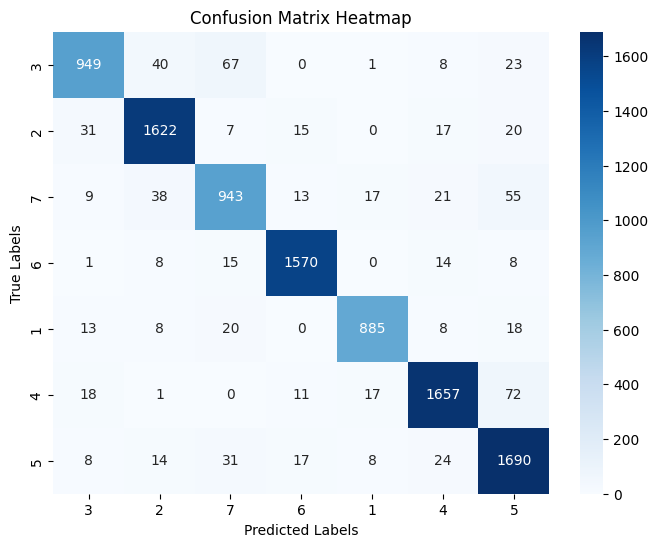

Best Parameters: {'max_depth': 20, 'n_estimators': 1000}
Accuracy: 92.86283891547049 %
Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.87      0.90      1088
           2       0.94      0.95      0.94      1712
           3       0.87      0.86      0.87      1096
           4       0.97      0.97      0.97      1616
           5       0.95      0.93      0.94       952
           6       0.95      0.93      0.94      1776
           7       0.90      0.94      0.92      1792

    accuracy                           0.93     10032
   macro avg       0.93      0.92      0.92     10032
weighted avg       0.93      0.93      0.93     10032



In [53]:
random_tree_model = RandomForestClassifier(random_state=42)
train_model(random_tree_model,param_grid,X_train,y_train,X_test,y_test)

**Random Forest with feature engineering**

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....................max_depth=20, n_estimators=1000; total time= 1.6min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 1.7min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 1.7min


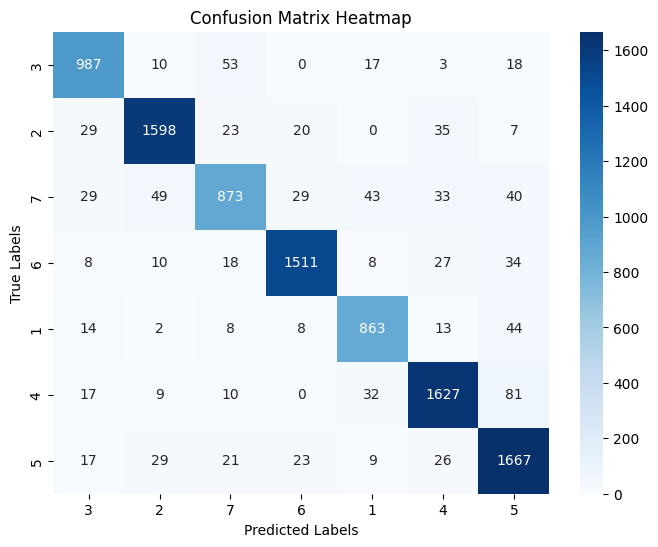

Best Parameters: {'max_depth': 20, 'n_estimators': 1000}
Accuracy: 90.9688995215311 %
Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.91      0.90      1088
           2       0.94      0.93      0.93      1712
           3       0.87      0.80      0.83      1096
           4       0.95      0.94      0.94      1616
           5       0.89      0.91      0.90       952
           6       0.92      0.92      0.92      1776
           7       0.88      0.93      0.91      1792

    accuracy                           0.91     10032
   macro avg       0.91      0.90      0.90     10032
weighted avg       0.91      0.91      0.91     10032



In [54]:
train_model(random_tree_model,param_grid,X_train_feature_eng,y_train,X_test_feature_eng,y_test)

**Multilayer Perceptron**

In [55]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],  
    # 'activation': ['relu', 'tanh'],  
    # 'solver': ['adam', 'sgd'],  
    # 'alpha': [0.0001, 0.001, 0.01],  
    # 'learning_rate': ['constant', 'adaptive'],  
    # 'max_iter': [200, 500, 1000]  
}

**Multilayer Perceptron with no feature engineering**

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...........................hidden_layer_sizes=(50,); total time=  12.0s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...........................hidden_layer_sizes=(50,); total time=  13.6s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...........................hidden_layer_sizes=(50,); total time=  14.8s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........................hidden_layer_sizes=(100,); total time=  17.7s
[CV] END ..........................hidden_layer_sizes=(100,); total time=  17.8s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........................hidden_layer_sizes=(100,); total time=  19.8s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


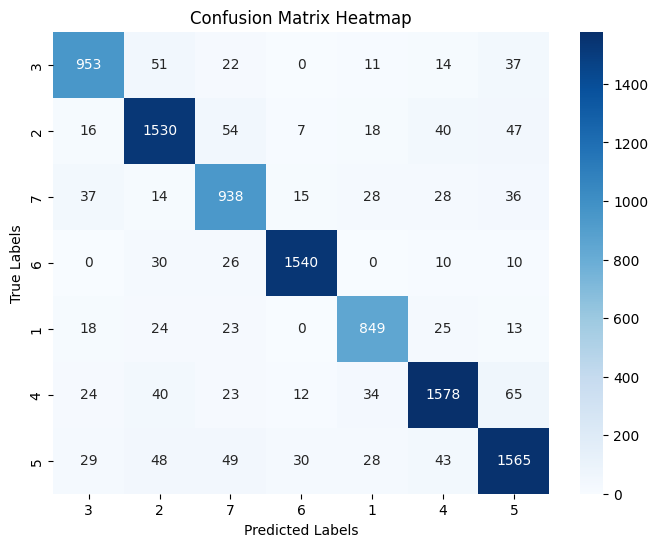

Best Parameters: {'hidden_layer_sizes': (100,)}
Accuracy: 89.24441786283892 %
Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.88      0.88      1088
           2       0.88      0.89      0.89      1712
           3       0.83      0.86      0.84      1096
           4       0.96      0.95      0.96      1616
           5       0.88      0.89      0.88       952
           6       0.91      0.89      0.90      1776
           7       0.88      0.87      0.88      1792

    accuracy                           0.89     10032
   macro avg       0.89      0.89      0.89     10032
weighted avg       0.89      0.89      0.89     10032



In [56]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Multilayer Perceptron with feature engineering**

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ...........................hidden_layer_sizes=(50,); total time=   9.7s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   9.8s
[CV] END ...........................hidden_layer_sizes=(50,); total time=   9.8s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........................hidden_layer_sizes=(100,); total time=  12.8s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ..........................hidden_layer_sizes=(100,); total time=  13.3s
[CV] END ..........................hidden_layer_sizes=(100,); total time=  13.4s


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


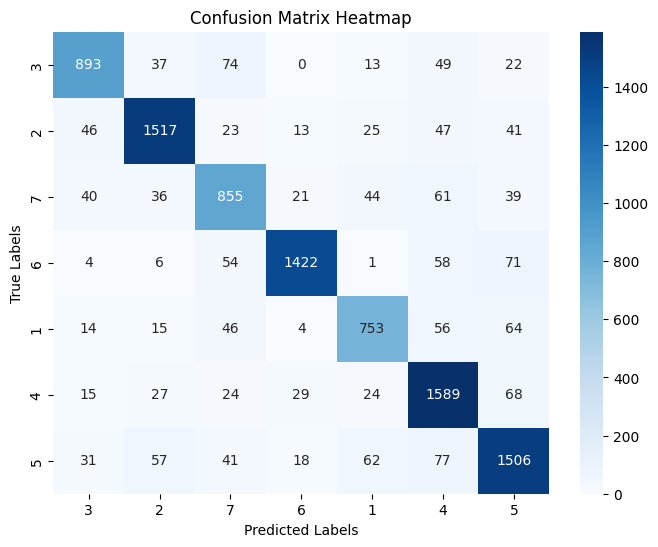

Best Parameters: {'hidden_layer_sizes': (100,)}
Accuracy: 85.07775119617224 %
Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.82      0.84      1088
           2       0.89      0.89      0.89      1712
           3       0.77      0.78      0.77      1096
           4       0.94      0.88      0.91      1616
           5       0.82      0.79      0.80       952
           6       0.82      0.89      0.86      1776
           7       0.83      0.84      0.84      1792

    accuracy                           0.85     10032
   macro avg       0.85      0.84      0.84     10032
weighted avg       0.85      0.85      0.85     10032



In [57]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Support Vector Machines**

In [58]:
param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto'],  
}

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.3min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 1.3min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 1.3min


/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.3min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 1.3min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 1.3min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.7min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.7min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time= 1.9min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  48.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  57.0s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=  44.4s
[CV] END ...................

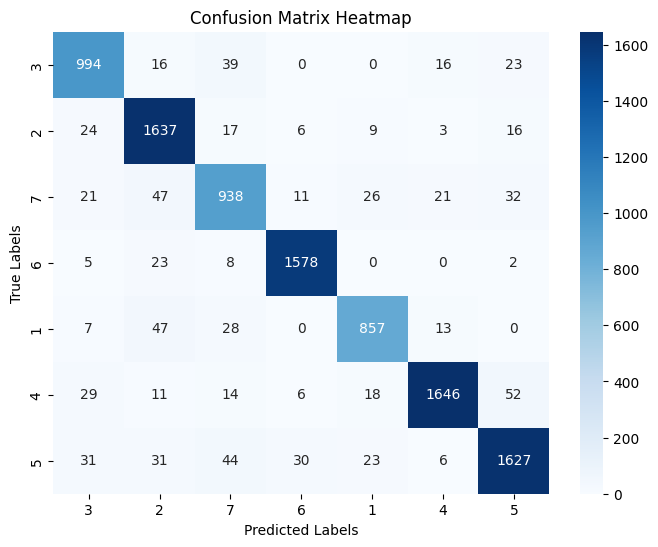

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 92.47408293460924 %
Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.91      0.90      1088
           2       0.90      0.96      0.93      1712
           3       0.86      0.86      0.86      1096
           4       0.97      0.98      0.97      1616
           5       0.92      0.90      0.91       952
           6       0.97      0.93      0.95      1776
           7       0.93      0.91      0.92      1792

    accuracy                           0.92     10032
   macro avg       0.92      0.92      0.92     10032
weighted avg       0.93      0.92      0.92     10032



In [59]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  40.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  41.7s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  47.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  52.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  53.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  54.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  52.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  53.1s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  56.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.0min
[CV] END ......................C=0.1, gamma=auto

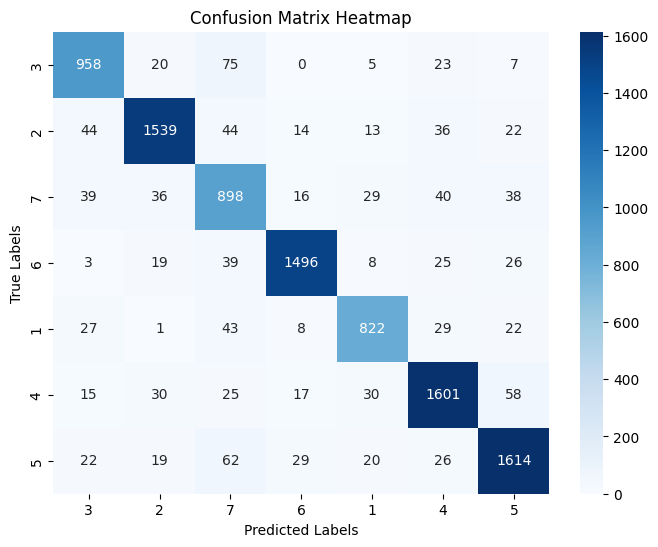

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 88.99521531100478 %
Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.88      0.87      1088
           2       0.92      0.90      0.91      1712
           3       0.76      0.82      0.79      1096
           4       0.95      0.93      0.94      1616
           5       0.89      0.86      0.87       952
           6       0.90      0.90      0.90      1776
           7       0.90      0.90      0.90      1792

    accuracy                           0.89     10032
   macro avg       0.88      0.88      0.88     10032
weighted avg       0.89      0.89      0.89     10032



In [60]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Upsampling the training dataset, then comparing the results to above**
- Applying SMOTE to make sure all classes are evenly distributed